In [48]:
# Always reload packages before executing user code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Basic imports
import scanpy as sc

import sys, os

# Add parent directory to Python path
sys.path.append(os.path.abspath(".."))  

# Import pipeline functions
from scrna_pipeline import standard_scrna_pipeline

# (Optional) make Scanpy plots a bit nicer / consistent
sc.settings.verbosity = 1     
sc.logging.print_header()      # print version info
sc.settings.set_figure_params(dpi=100, facecolor="white")


In [50]:
# Path to raw AnnData file (adjust as needed)
raw_path = "/Users/alahi.irfan/Desktop/Local_workspace/Data/Chen_NatureCellBiol_2021/GSE141445_RAW/GSM4203181_data.h5ad"#'/Users/alahi.irfan/Desktop/Local_workspace/Data/Melms_Nature_2021/GSE171524_RAW_merged.h5ad'#"/Users/alahi.irfan/Desktop/Local_workspace/Data/Zheng_CancerCell_2024/GSE222315_RAW/merged_BCa_NAT.h5ad"

# Read the raw data
adata_raw = sc.read_h5ad(raw_path)

print(adata_raw)
adata_raw.obs.head()


AnnData object with n_obs × n_vars = 36424 × 25044
    obs: 'sample'
    layers: 'counts'


,sample
AAACCTGAGAGATGAG-1,1
AAACCTGCACCAGGCT-1,1
AAACCTGGTTAAGACA-1,1
AAACCTGGTTGAGTTC-1,1
AAACGGGCACGACGAA-1,1


In [51]:
print(adata_raw.var_names[:5])
print(adata_raw.obs_names[:5])

Index(['RP11-34P13.7', 'RP11-34P13.8', 'FO538757.2', 'AP006222.2',
       'RP4-669L17.10'],
      dtype='object')
Index(['AAACCTGAGAGATGAG-1', 'AAACCTGCACCAGGCT-1', 'AAACCTGGTTAAGACA-1',
       'AAACCTGGTTGAGTTC-1', 'AAACGGGCACGACGAA-1'],
      dtype='object')


In [54]:
# Choose the column in adata.obs that encodes batch / sample.
# If you have no batches, you can set batch_key=None and batch_method="none".
batch_key = "sample"   # change if your column is named differently

# Run the standard pipeline:
# - QC + filters + Scrublet
# - HVGs (Seurat v3 on counts by default)
# - normalize/log + scale + PCA
# - Harmony batch correction
# - neighbors + Leiden + UMAP
adata_proc = standard_scrna_pipeline(
    adata_raw,
    batch_key=batch_key,

    # batch correction method
    batch_method="harmony",

    # HVG selection
    hvg_flavor="seurat_v3", # "seurat", #"seurat_v3",
    n_top_genes=2000,

    # clustering
    clustering_method="leiden",

    # 👇 All preprocessing options go here
    preprocess_kwargs={
        "use_ribo_filter": False,
        "use_mito_filter": True
    },
)


print(adata_proc)



[ scrna-pipeline ] Running standard scRNA-seq pipeline
  • Input AnnData shape: 36424 cells × 25044 genes
  • Batch key:         'sample'
  • Batch method:      'harmony'
  • HVG flavor:        'seurat_v3'
  • n_top_genes:       2000
  • n_pcs:             50
  • Clustering:        'leiden'
  • Cluster resol.:    0.6
  • Preprocess kwargs: {'use_mito_filter': True, 'use_ribo_filter': False}
  • Batch kwargs:      {}
  • Cluster kwargs:    {}

Running Scrublet for doublet detection...
Removed 295 predicted doublets
After doublet removal: (35268, 24391)


/opt/miniconda3/envs/scrna-pipeline/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-12-04 15:01:52,463 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


[ scrna-pipeline ] Step 1 complete: preprocess_to_pca
  • PCA stored in .obsm['X_pca']
  • Genes after HVG selection: 2000
  • Cells after QC / Scrublet: 35268

Running Harmony batch correction using batch_key='sample'...


2025-12-04 15:01:53,904 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-12-04 15:01:53,962 - harmonypy - INFO - Iteration 1 of 10
2025-12-04 15:01:58,073 - harmonypy - INFO - Iteration 2 of 10
2025-12-04 15:02:02,381 - harmonypy - INFO - Iteration 3 of 10
2025-12-04 15:02:06,051 - harmonypy - INFO - Iteration 4 of 10
2025-12-04 15:02:10,277 - harmonypy - INFO - Iteration 5 of 10
2025-12-04 15:02:15,736 - harmonypy - INFO - Converged after 5 iterations


[ scrna-pipeline ] Step 2 complete: batch correction with 'harmony'
  • Corrected embedding stored in .obsm['X_pca_harmony']

[ scrna-pipeline ] Step 3 complete: clustering + UMAP
  • Cluster labels in .obs['leiden']
  • UMAP stored in .obsm['X_umap']
  • Final AnnData shape: 35268 cells × 2000 genes

AnnData object with n_obs × n_vars = 35268 × 2000
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'scrublet', 'hvg', '

In [55]:
adata_proc.uns["scrna_pipeline"]["standard_pipeline"]


{'batch_key': 'sample',
 'batch_method': 'harmony',
 'hvg_flavor': 'seurat_v3',
 'n_top_genes': 2000,
 'n_pcs': 50,
 'n_neighbors': 15,
 'clustering_method': 'leiden',
 'cluster_resolution': 0.6,
 'preprocess_kwargs': {'use_ribo_filter': False, 'use_mito_filter': True},
 'batch_kwargs': {},
 'cluster_kwargs': {}}

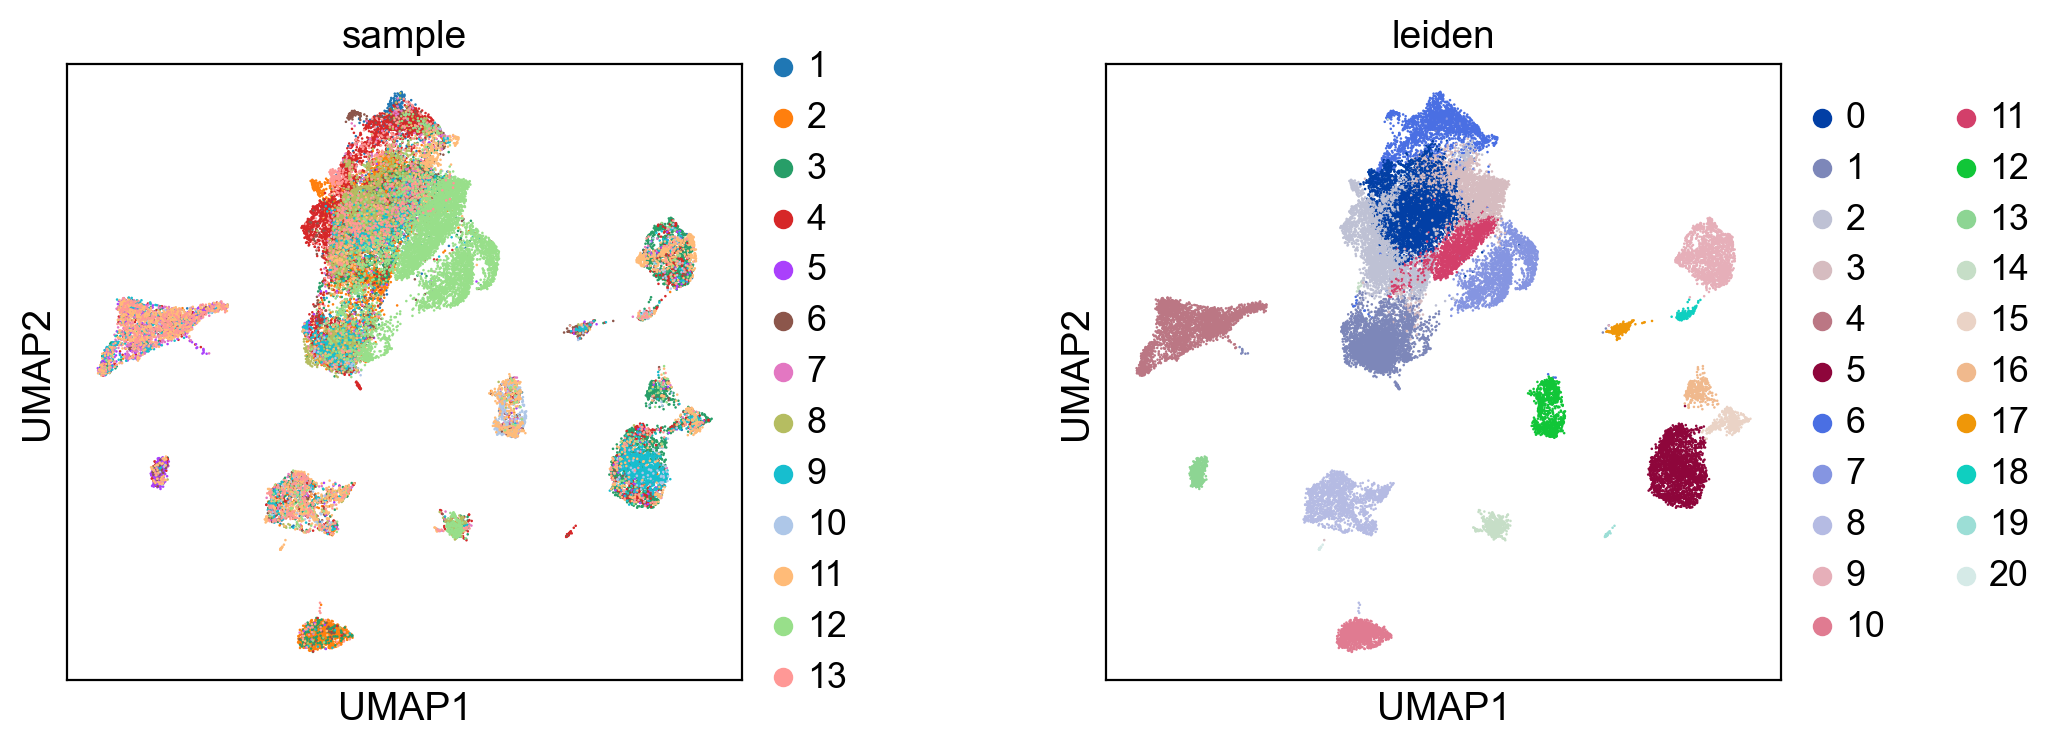

In [56]:
# Quick UMAP overview:
# - color by batch (e.g. "sample")
# - color by cluster ("louvain")
umap_colors = []

if "sample" in adata_proc.obs.columns:
    umap_colors.append("sample")

if "condition" in adata_proc.obs.columns:   # only if present in your data
    umap_colors.append("condition")

if "louvain" in adata_proc.obs.columns:
    umap_colors.append("louvain")

if "leiden" in adata_proc.obs.columns:
    umap_colors.append("leiden")

sc.pl.umap(
    adata_proc,
    color=umap_colors,
    wspace=0.4,
)


In [57]:
from scrna_pipeline.annotation import score_markers_and_suggest_labels

# ------------------------------------------------------------------
# 1) Define marker dictionary (unchanged)
# ------------------------------------------------------------------
marker_dict = {
    # -----------------------
    # Epithelial subtypes
    # -----------------------
    "Epi_Luminal": [
        "EPCAM", "KRT8", "KRT18", "KRT19",
        "MUC1",
    ],
    "Epi_Basal": [
        "KRT5", "KRT14", "KRT17", "TP63",
    ],
    "Epi_Cycling": [
        "MKI67", "TOP2A", "BIRC5", "CCNB1", "CDC20",
    ],

    # -----------------------
    # Immune lineages
    # -----------------------
    "T_cell": [
        "CD3D", "CD3E", "CD2", "CD8A", "CD4",
    ],
    "B_cell": [
        "MS4A1", "CD79A", "CD79B",
    ],
    "Myeloid": [
        "LYZ", "S100A8", "S100A9", "LGALS3",
    ],

    # -----------------------
    # Stromal + mast
    # -----------------------
    "Endothelial": [
        "PECAM1", "VWF", "KDR",
    ],
    "Fibroblast": [
        "COL1A1", "COL1A2", "DCN", "LUM",
    ],
    "Mast": [
        "TPSAB1", "TPSB2", "CPA3", "KIT", "HDC", "MS4A2",
    ],
}

# ------------------------------------------------------------------
# 2) Pick a cluster column automatically
# ------------------------------------------------------------------
if "leiden" in adata_proc.obs:
    cluster_key = "leiden"
elif "louvain" in adata_proc.obs:
    cluster_key = "louvain"
elif "cluster" in adata_proc.obs:
    # in case you manually created a generic cluster column
    cluster_key = "cluster"
else:
    raise ValueError(
        "No clustering column found in `adata.obs`. "
        "Expected one of: 'leiden', 'louvain', or 'cluster'."
    )

print(f"Using cluster_key = '{cluster_key}' for marker-based annotation.")

# ------------------------------------------------------------------
# 3) Score markers and get suggested labels
# ------------------------------------------------------------------
cluster_scores, suggested = score_markers_and_suggest_labels(
    adata_proc,
    marker_dict=marker_dict,
    cluster_key=cluster_key,
)

# ------------------------------------------------------------------
# 4) Pretty display (with fallback if styling fails)
# ------------------------------------------------------------------
try:
    display(
        cluster_scores
        .round(2)
        .style
        .background_gradient(cmap="viridis")
        .set_properties(**{"text-align": "center"})
        .set_table_styles([
            dict(selector="th", props=[("text-align", "center")]),
        ])
    )
except Exception as e:
    # e.g. jinja2 not installed or in non-notebook context
    print("Styled display failed, showing plain table instead:", repr(e))
    display(cluster_scores.round(2))

# If you want, you can also inspect the suggested labels:
suggested


Using cluster_key = 'leiden' for marker-based annotation.


/Users/alahi.irfan/Desktop/Local_workspace/scRNA-seq-pipeline/scrna_pipeline/annotation.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cluster_key)[score_cols]


,Epi_Luminal,Epi_Basal,Epi_Cycling,T_cell,B_cell,Myeloid,Endothelial,Fibroblast,Mast
leiden,,,,,,,,,
0,0.470000,-0.020000,-0.010000,-0.140000,-0.040000,-0.140000,-0.160000,-0.070000,-0.160000
1,0.370000,-0.000000,-0.000000,-0.060000,-0.010000,-0.050000,-0.080000,-0.030000,-0.050000
2,0.350000,-0.020000,-0.010000,-0.110000,-0.030000,-0.120000,-0.130000,-0.060000,-0.110000
3,0.290000,-0.030000,-0.010000,-0.140000,-0.040000,-0.160000,-0.160000,-0.070000,-0.150000
4,-0.230000,-0.020000,-0.010000,0.930000,0.010000,-0.030000,-0.100000,-0.040000,-0.120000
5,-0.290000,-0.040000,-0.030000,-0.120000,-0.060000,0.020000,1.250000,-0.070000,-0.160000
6,0.720000,-0.030000,-0.020000,-0.150000,-0.050000,0.040000,-0.170000,-0.070000,-0.200000
7,0.390000,-0.030000,-0.000000,-0.130000,-0.040000,-0.180000,-0.160000,-0.070000,-0.170000
8,-0.310000,-0.020000,0.010000,0.100000,-0.030000,0.980000,-0.050000,-0.060000,-0.120000


leiden
0     Epi_Luminal
1     Epi_Luminal
2     Epi_Luminal
3     Epi_Luminal
4          T_cell
5     Endothelial
6     Epi_Luminal
7     Epi_Luminal
8         Myeloid
9      Fibroblast
10           Mast
11    Epi_Luminal
12    Epi_Luminal
13         B_cell
14    Epi_Cycling
15    Endothelial
16    Endothelial
17     Fibroblast
18     Fibroblast
19    Endothelial
20        Myeloid
dtype: object

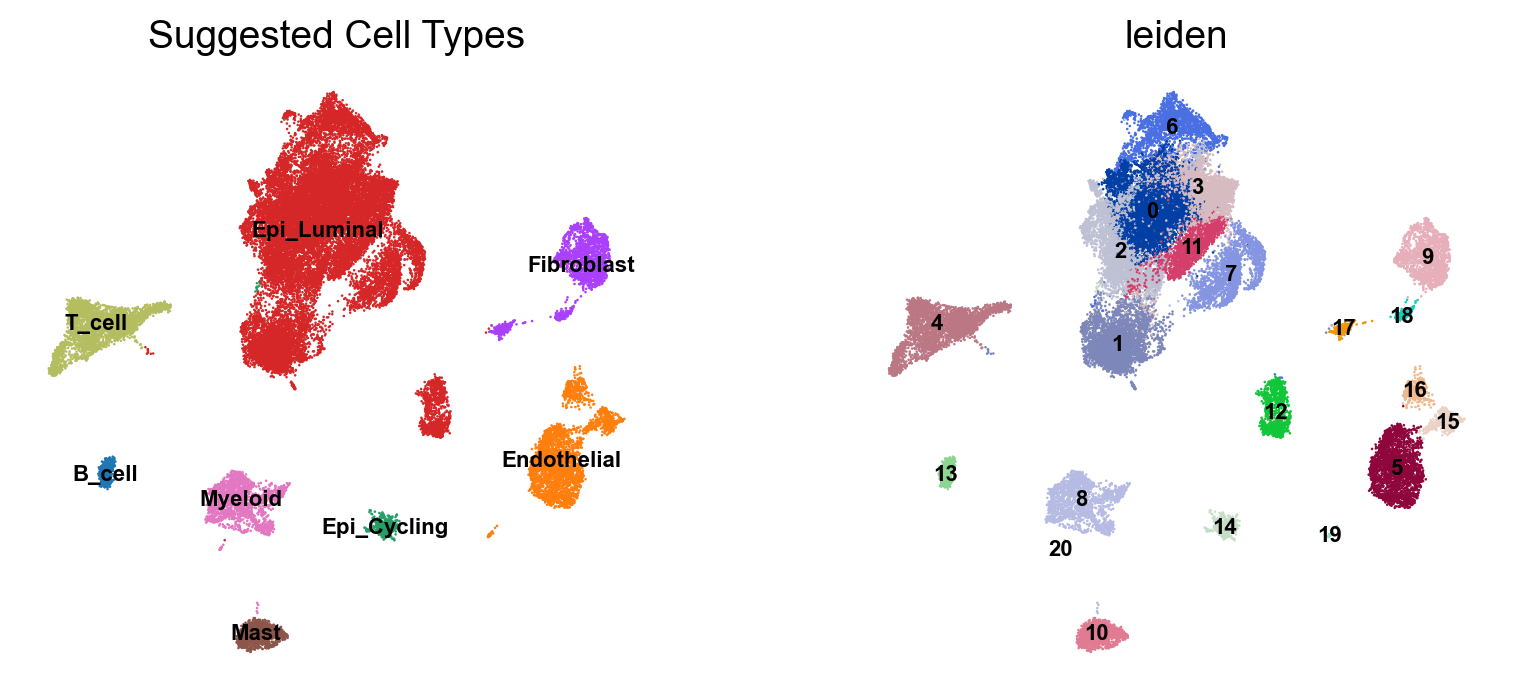

In [58]:


# Attach suggested labels for plotting
adata_proc.obs["celltype"] = adata_proc.obs[cluster_key].map(suggested)


sc.pl.umap(
    adata_proc,
    color=["celltype",cluster_key],
    legend_loc="on data",
    legend_fontsize=8,
    frameon=False,
    title="Suggested Cell Types",
)

/opt/miniconda3/envs/scrna-pipeline/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/opt/miniconda3/envs/scrna-pipeline/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/opt/miniconda3/envs/scrna-pipeline/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:463: Perf

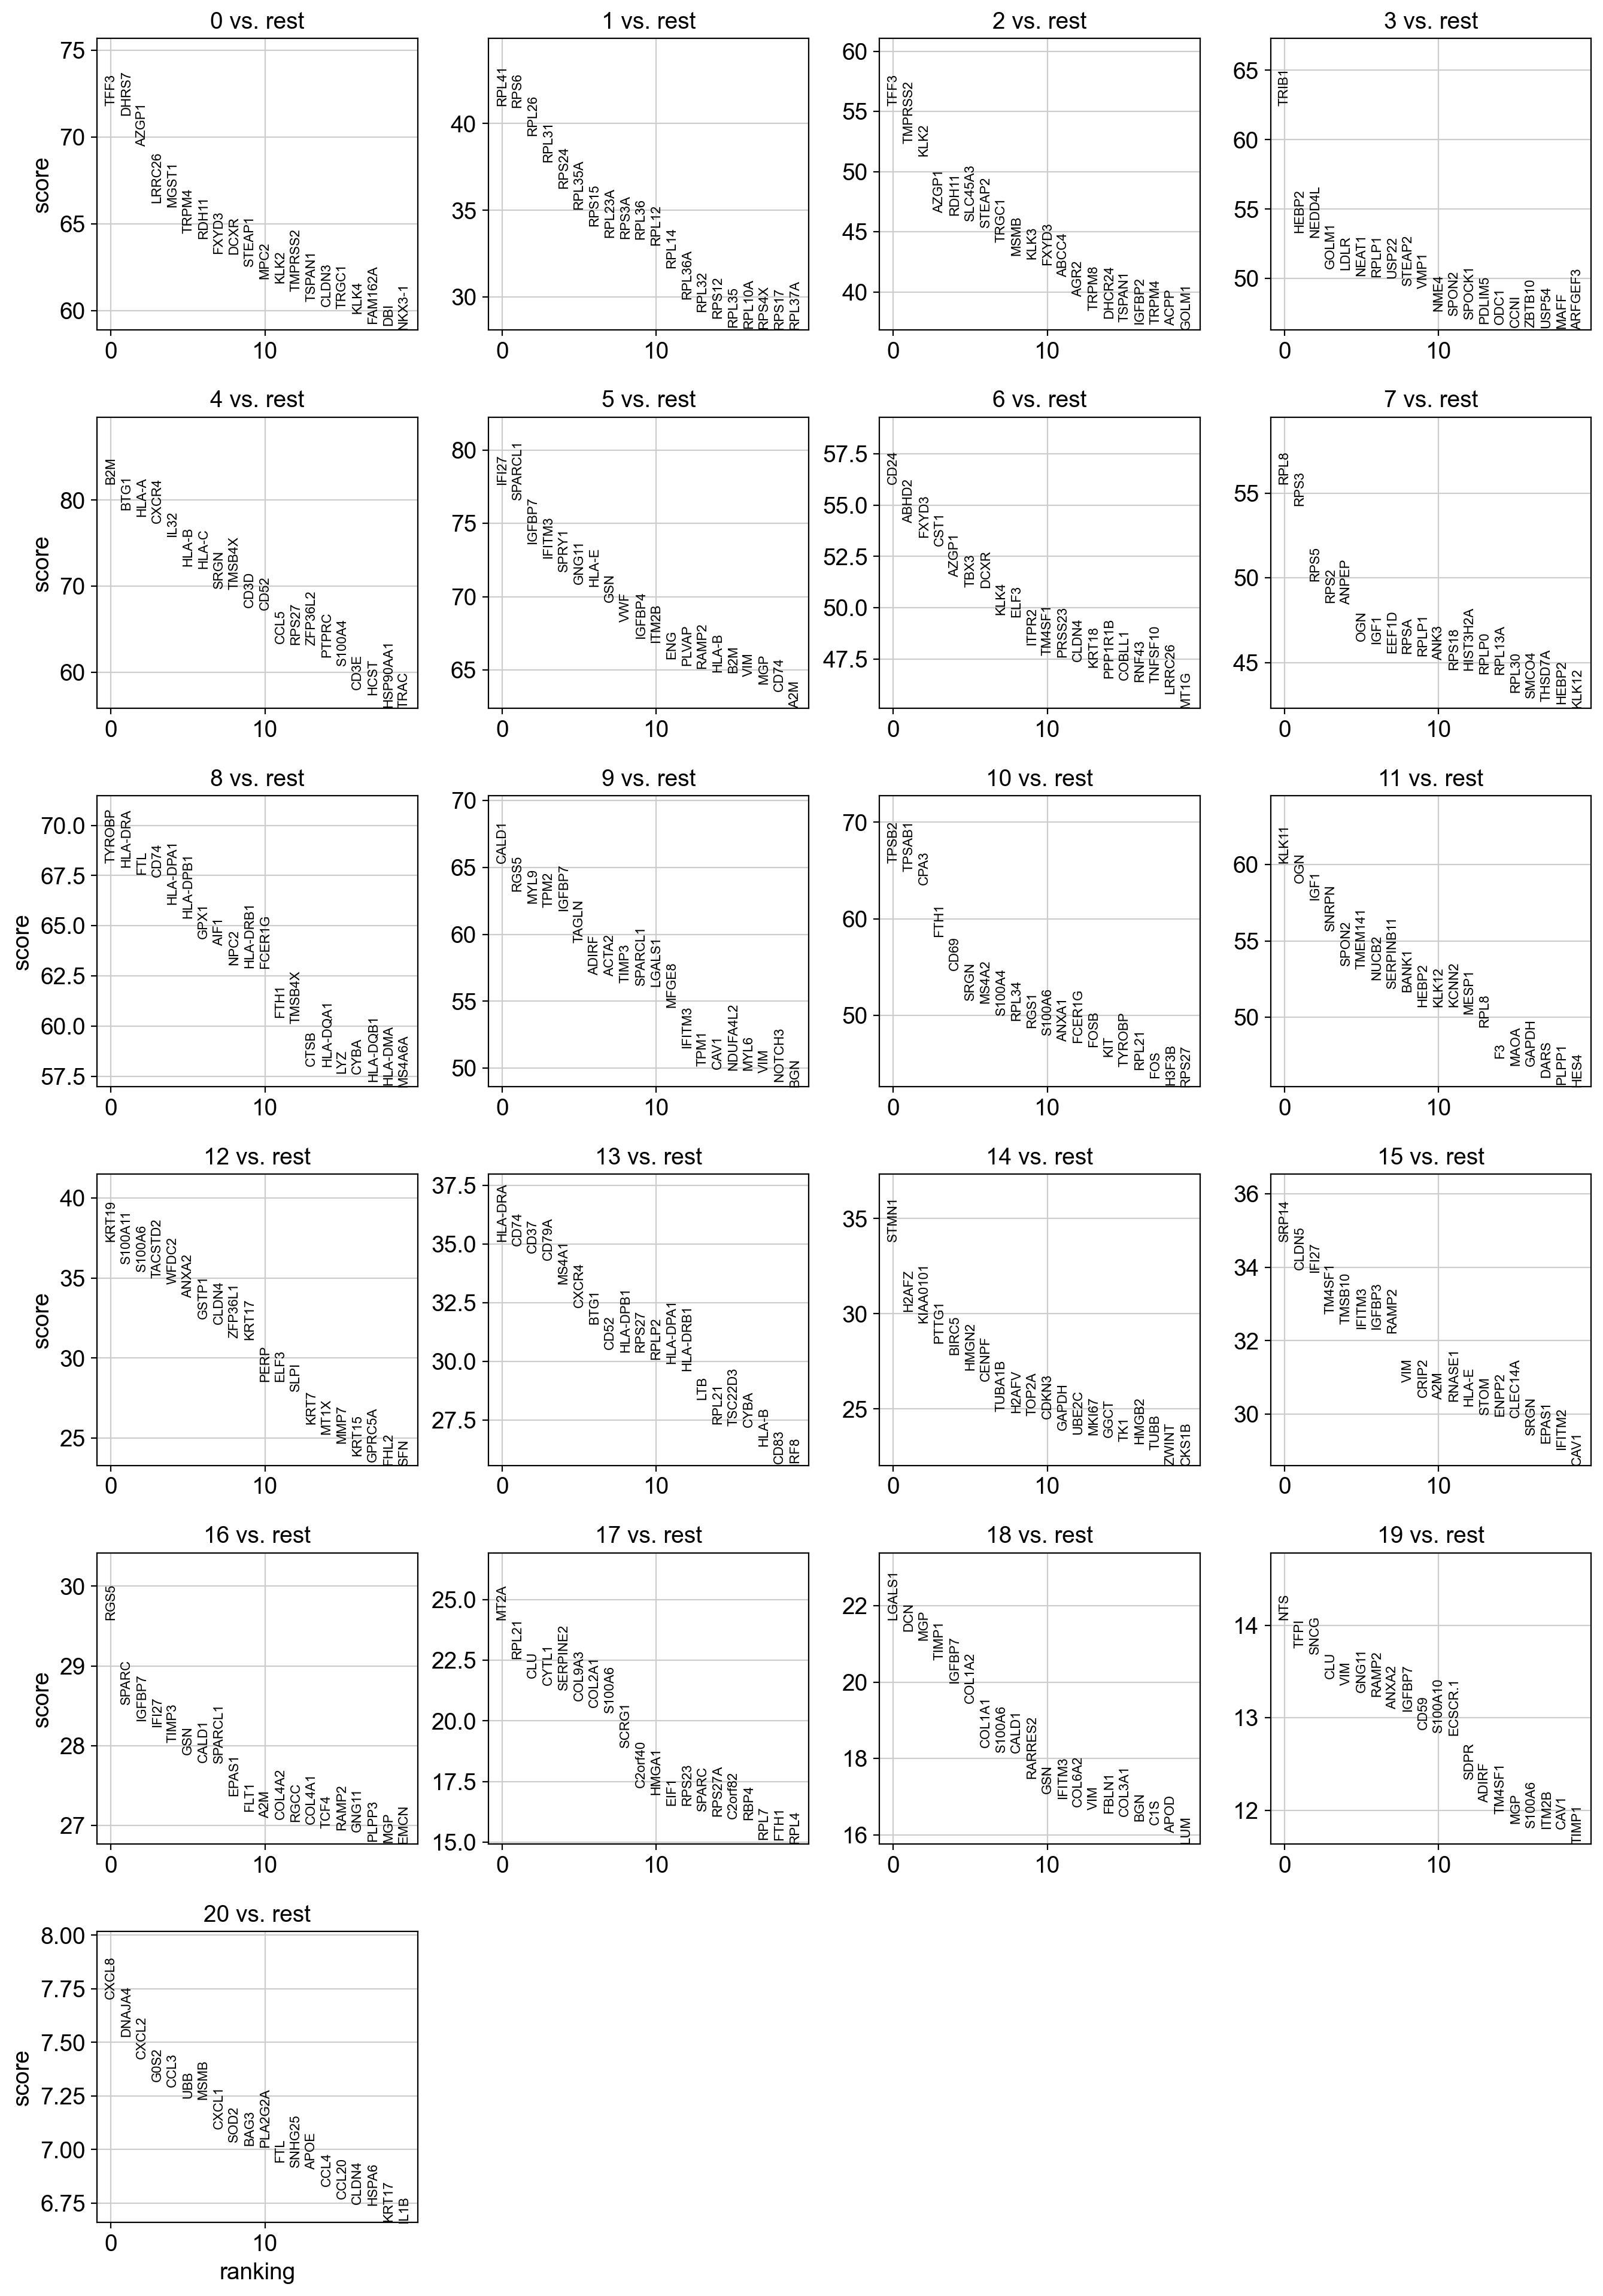

In [59]:




sc.tl.rank_genes_groups(
    adata_proc,
    groupby=cluster_key,
    reference="rest",
    method="wilcoxon",
)

sc.pl.rank_genes_groups(adata_proc, n_genes=20, sharey=False)

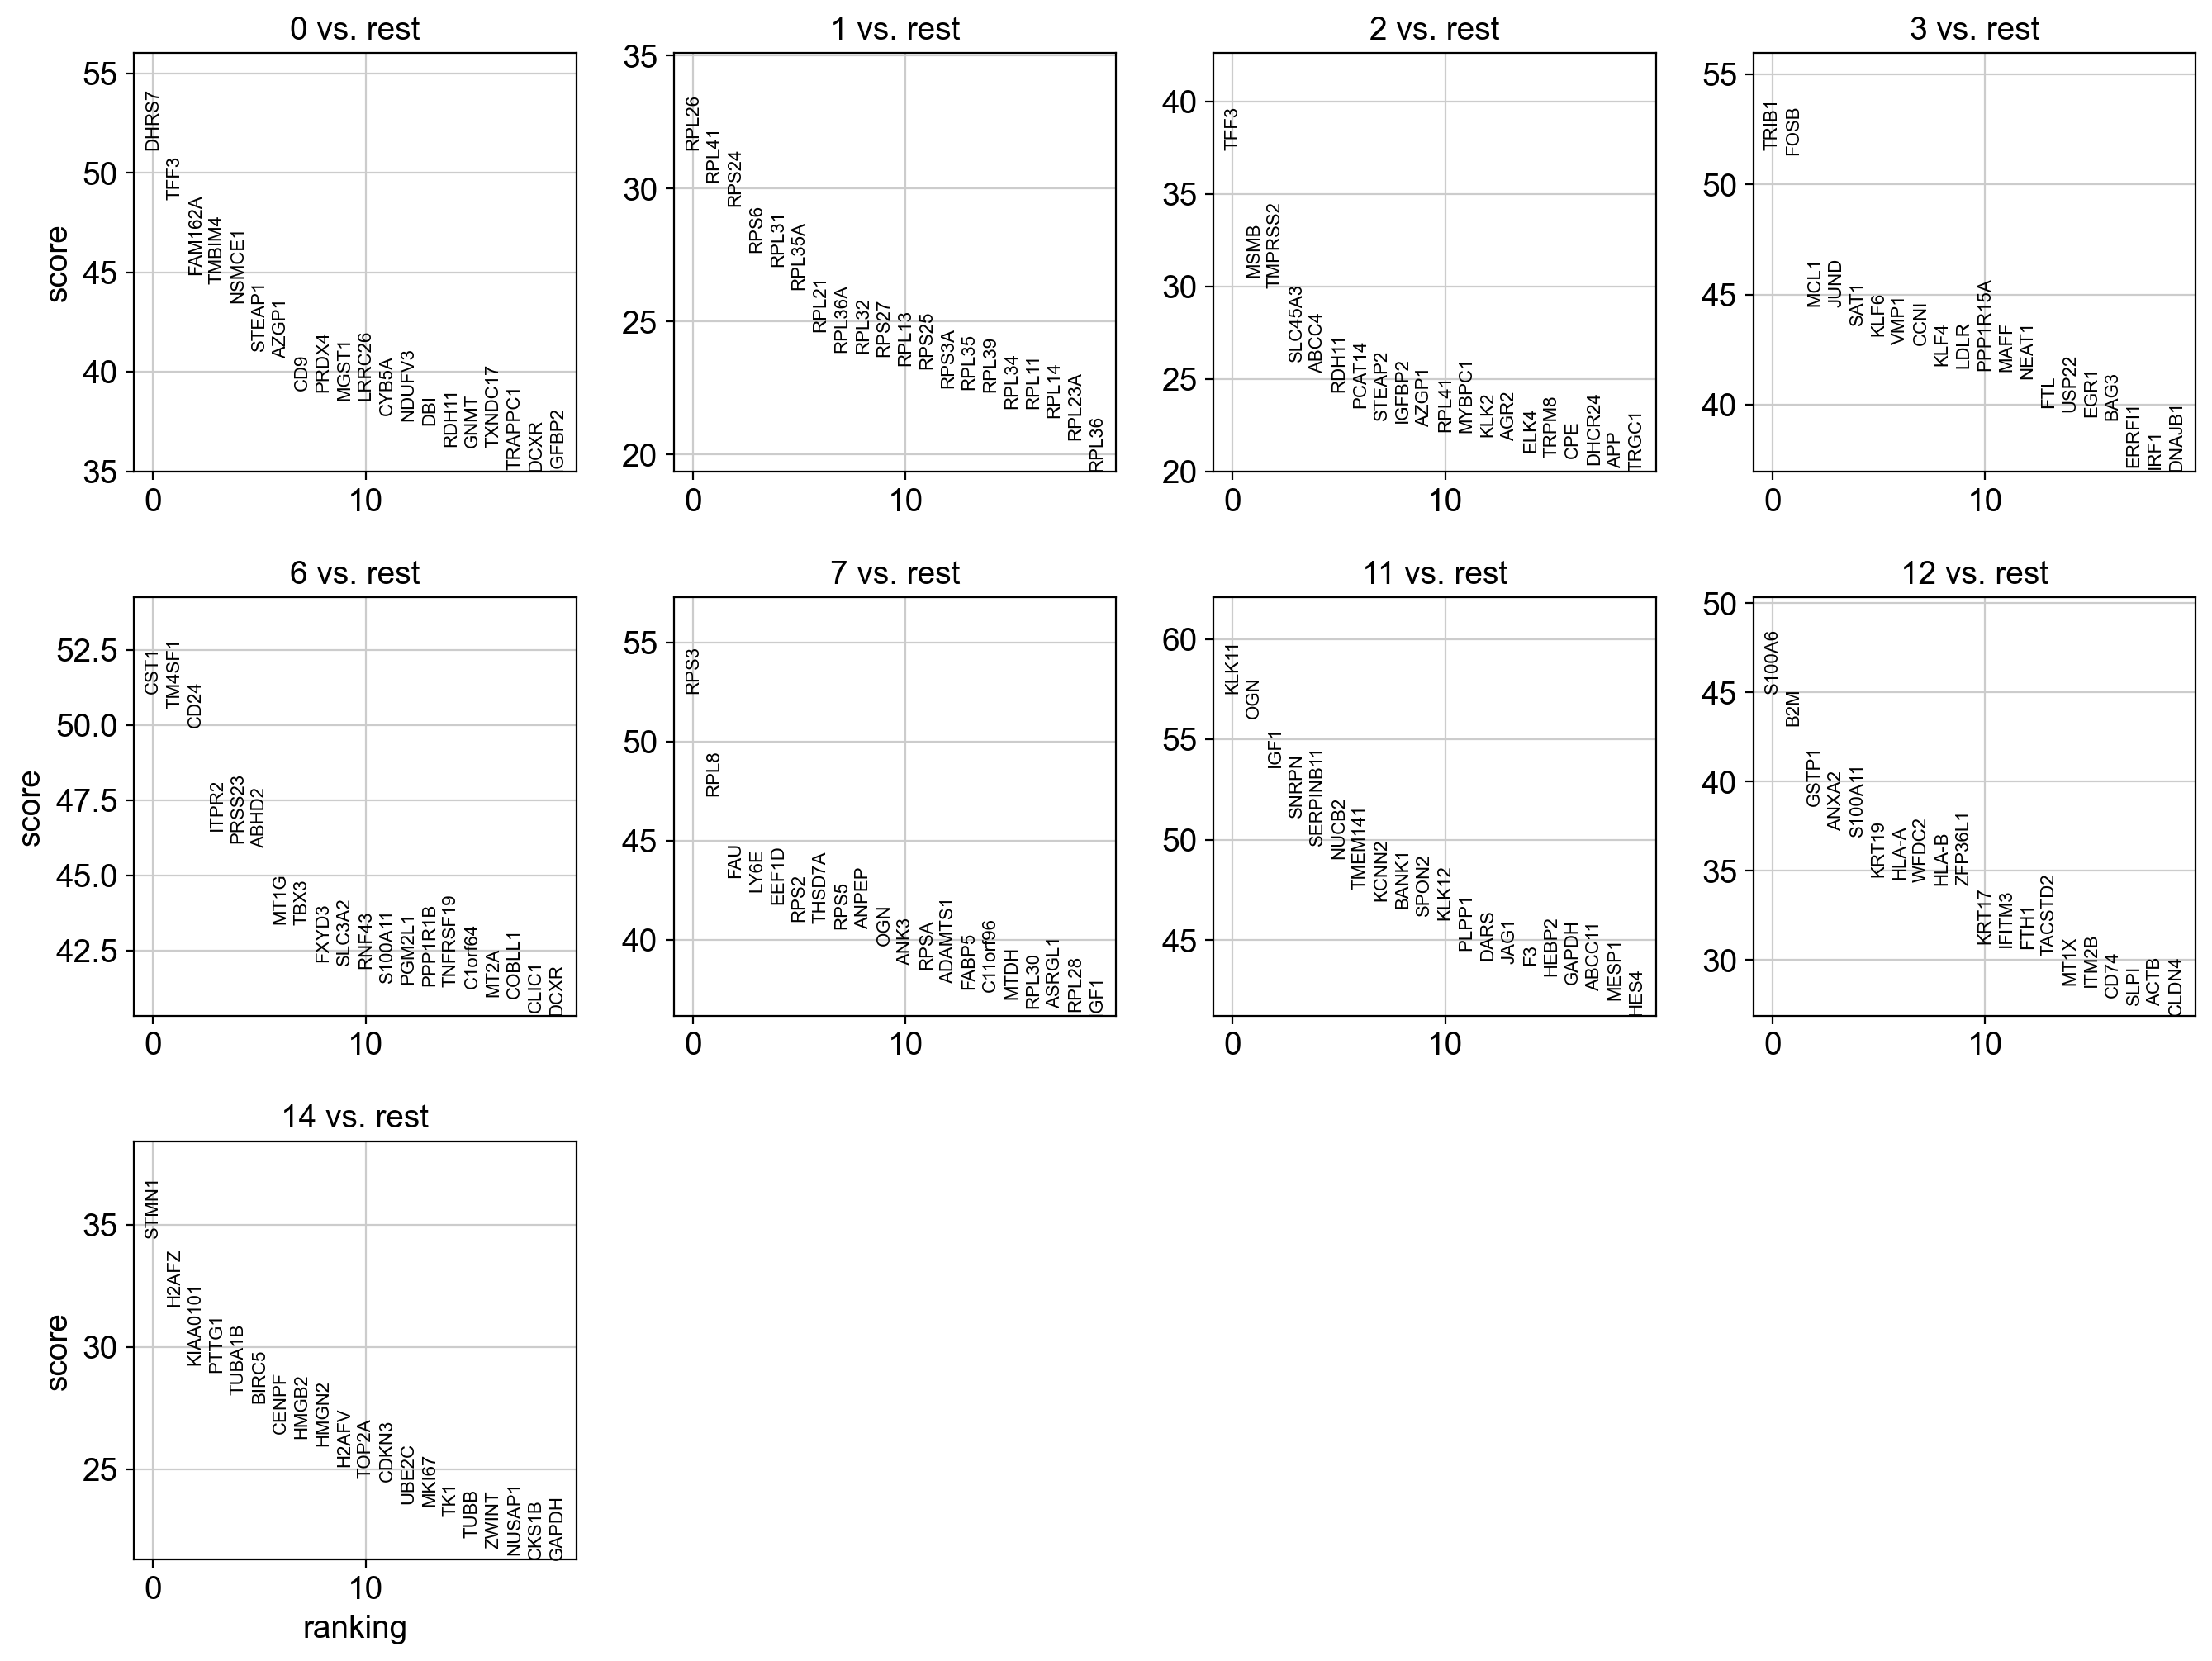

In [60]:


# Subset to epithelial-related types only
epi = adata_proc[adata_proc.obs["celltype"].isin(["Epi_Luminal", "Epi_Cycling"]), :].copy()

# Use existing clusters within this epi subset
sc.tl.rank_genes_groups(
    epi,
    groupby=cluster_key,
    reference="rest",
    method="wilcoxon",
)

sc.pl.rank_genes_groups(epi, n_genes=20, sharey=False)
